In [54]:
!pip install imblearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas_profiling as pp
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
!pip install shap

In [55]:
!pip install pandas_profiling

In [146]:
def wrangle(X):
    X = X.copy()


    #add target features
    X['substantiated'] = X['board_disposition'].str.contains('Substantiated')
    X = X.drop(columns='board_disposition')
    
    #add new feature (multiple complaints)
    #X['multiple_complaints'] = X.duplicated(subset='unique_mos_id', keep=False) & X.duplicated(subset='complaint_id', keep=False) 
    # X['lots of allegations'] = X['unique_mos_id'].value_counts() >= 10      
    # X = X.drop(columns='unique_mos_id', 'complaint_id')


    #add new feature (length of review in months)
    X['review_length_mo'] = ((X['year_closed'] *12) + X['month_closed']) - ((X['year_received']*12) + X['month_received'])

    #drop rows with zero in sheild_no
    X = X.loc[(X['shield_no']!=0)]

    #drop unneded cols
    #maybe i dont need these idk but im keeping rn,    'rank_incident', 'complainant_ethnicity', 'complainant_gender' , 'mos_ethnicity' 
    unneded_col = ['first_name', 'last_name', 'rank_abbrev_incident','rank_now', 'command_now', 'rank_abbrev_now', 'unique_mos_id',  'shield_no', 'command_at_incident', 'year_closed', 'month_closed', 'month_received', 'fado_type', 'mos_ethnicity', 'complaint_id'   ]
    X = X.drop(columns=unneded_col)

    #change index to year recieved
    X = X.set_index('year_received')
    X = X.sort_index()

    #drop duplicated rows
    X.drop_duplicates(keep='first', inplace=True)

    #X.dropna(inplace=True, how='any')
    return X

In [147]:
df = pd.read_csv(r'C:/Users/megal/OneDrive/Desktop/Lambda/blog_2_data/allegations.csv')

In [148]:
df.head()
df.shape

(33358, 27)

In [149]:
#set up new dataframe to make feature
lots_of_allegations = df['unique_mos_id'].value_counts(dropna=False).rename_axis('unique_mos_id').reset_index(name='counts')

In [150]:
#officers with more than 10 ccrb reports
lots_of_allegations['lots_of_allegations'] = (lots_of_allegations['counts'] >=10)

In [151]:
lots_of_allegations = lots_of_allegations.drop(columns='counts')

In [152]:
lots_of_allegations.head()

,unique_mos_id,lots_of_allegations
0,25861,True
1,18731,True
2,19489,True
3,18530,True
4,18589,True


In [153]:
#merge lots of allegations based on the unique member of sevice ID
df = df.merge(lots_of_allegations, on='unique_mos_id')

In [154]:
df = wrangle(df)

In [155]:
df.head()

,rank_incident,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,allegation,precinct,contact_reason,outcome_description,lots_of_allegations,substantiated,review_length_mo
year_received,,,,,,,,,,,,,
1985,Police Officer,M,23,NaN,NaN,NaN,Arrest/Onlooker,71.0,Report of Crime Past/Present,No arrest made or summons issued,True,False,0
1985,Police Officer,M,23,NaN,NaN,NaN,Dragged/Pulled,71.0,Report of Crime Past/Present,No arrest made or summons issued,True,False,0
1985,Police Officer,M,23,NaN,NaN,NaN,Punch/Kick,63.0,Dispute,No arrest made or summons issued,True,True,0
1986,Police Officer,M,22,NaN,NaN,NaN,Sh Refuse Cmp,70.0,Summons/Complainant,Traffic Summons Claimed or Issued,False,True,0
1986,Police Officer,M,22,NaN,NaN,NaN,Dragged/Pulled,70.0,Report of Crime Past/Present,No arrest made or summons issued,False,False,0


In [583]:
df.profile_report()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


In [138]:
#make sure nothing in this feature looks weird

df['review_length_mo'].value_counts()

6      2253
5      2065
7      2017
10     1968
9      1923
8      1872
11     1809
12     1773
13     1733
4      1635
14     1597
15     1384
16     1320
17      934
0       876
3       742
18      641
19      237
2       140
20       67
21       63
23       31
22       22
25       20
24       17
1        17
27       13
34       13
35        6
69        6
29        5
26        5
75        4
31        4
40        3
33        3
41        2
28        2
55        1
51        1
66        1
45        1
37        1
110       1
47        1
Name: review_length_mo, dtype: int64

In [156]:
#split target matrix from dataframe

target = 'substantiated'
y = df[target]
X = df.drop(columns=target)

In [167]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = .5, random_state=42)

In [168]:
X_train.head()

,rank_incident,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,allegation,precinct,contact_reason,outcome_description,lots_of_allegations,review_length_mo
year_received,,,,,,,,,,,,
2009,Police Officer,F,25,Black,Male,27.0,Frisk,46.0,Other,Arrest - other violation/crime,True,17
2014,Police Officer,M,28,White,Male,32.0,Pepper spray,6.0,PD suspected C/V of violation/crime - street,Arrest - other violation/crime,False,9
2018,Police Officer,M,24,Black,Male,52.0,Gun fired,48.0,Report-dispute,No arrest made or summons issued,True,15
2016,Police Officer,M,29,Black,Male,38.0,Refusal to provide name/shield number,75.0,PD suspected C/V of violation/crime - street,Arrest - other violation/crime,False,3
2007,Police Officer,M,26,Black,Male,26.0,Physical force,101.0,PD suspected C/V of violation/crime - street,Arrest - other violation/crime,True,8


In [189]:
# # determine categorical and numerical features for training set
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns

# # determine categorical and numerical features for validation set
numerical_features_val = X_val.select_dtypes(include=['int64', 'float64']).columns
categorical_features_val = X_val.select_dtypes(include=['object', 'bool']).columns
## categorical ad numerical features for test set
numerical_features_test = X_test.select_dtypes(include=['int64', 'float64']).columns
categorical_features_test = X_test.select_dtypes(include=['object', 'bool']).columns


#pipeline for transforming categorical data columns
#stategy 'most_frequent' used to impute the categorical data
cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(),
 
)
num_pipe = make_pipeline(
    SimpleImputer(),
   
)
#column transformer for training data set
ct = ColumnTransformer(
    [('cat_pipe', cat_pipe, categorical_features),
     ('num_pipe', num_pipe, numerical_features)]
)
#transformer for test dataset 
ct_val = ColumnTransformer(
    [('cat_pipe', cat_pipe, categorical_features_val),
     ('num_pipe', num_pipe, numerical_features_val)]
)
#test transformer
ct_test = ColumnTransformer(
    [('cat_pipe', cat_pipe, categorical_features_test),
     ('num_pipe', num_pipe, numerical_features_test)]
)

In [190]:
#transform columns in training and test sets

XT_train = ct.fit_transform(X_train)
XT_val = ct_val.fit_transform(X_val)
XT_test = ct_test.fit_transform(X_test)

In [214]:

#baseline for model. Majority class (unsubstantiated(0)) extremely imbalanced
print('baseline:',y_train.value_counts(normalize=True).max())

baseline: 0.7377119422170533


In [191]:
#I used smote to normalize the baseline, so my models can actually predict passed the crazy imbalance
sm = SMOTE(random_state=42)
X_res_train, y_res_train = sm.fit_sample(XT_train, y_train)
X_res_val, y_res_val = sm.fit_sample(XT_val, y_val)

In [215]:
#extremely balanced baseline
print('smoted baseline', y_res_train.value_counts(normalize=True))

smoted baseline True     0.5
False    0.5
Name: substantiated, dtype: float64


In [216]:
#linear model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_res_train, y_res_train)

LogisticRegression(random_state=42)

In [217]:
print('logistic model acuracy score:', lr_model.score(X_res_train, y_res_train))
print('logistic model validation acuracy score:', lr_model.score(X_res_val, y_res_val))

logistic model acuracy score: 0.6237968801858612
logistic model validation acuracy score: 0.46957801766437685


In [218]:
#basic untuned random forest model fitting the trandformed training data. 
model_rf = RandomForestClassifier(
                                n_jobs=-1,
                                random_state=42)

model_rf.fit(XT_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [219]:
print('model rf training score:',model_rf.score(X_res_train, y_res_train))
print('model rf validation score:',model_rf.score(X_res_val, y_res_val))

model rf training score: 0.9002240292067707
model rf validation score: 0.478900883218842


<AxesSubplot:>

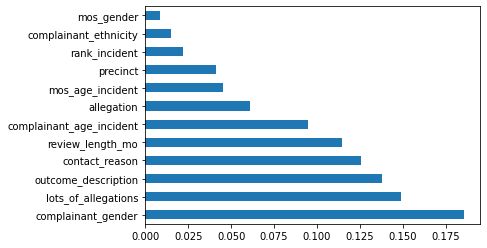

In [220]:
feat_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

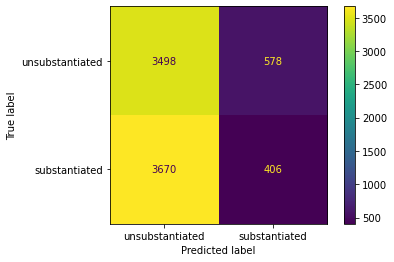

In [221]:

plot_confusion_matrix(model_rf,
                      X_res_val, #use validation data for confusion matrix
                      y_res_val,
                      values_format='.0f',
                      display_labels=['unsubstantiated', 'substantiated']);

In [537]:
#hyperparameter tuning for random forest model using grid search
params = {
    'max_depth': range(1,36,2),
    'n_estimators':range(55,75,5),
    'min_impurity_decrease': range(0,5,1),
    'max_features': range(0,10,1),
    'min_samples_leaf': range(0,5,1)
    
}
model = GridSearchCV(model_rf,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

In [442]:
model.fit(XT_train, y_train)

Fitting 5 folds for each of 18000 candidates, totalling 90000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2674 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3424 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4274 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 5224 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 6274 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 7424 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 8674 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 10024 tasks  

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 36, 2),
                         'max_features': range(0, 10),
                         'min_impurity_decrease': range(0, 5),
                         'min_samples_leaf': range(0, 5),
                         'n_estimators': range(55, 75, 5)},
             scoring='accuracy', verbose=1)

In [538]:
#parameters for my tuned model
model.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [222]:
#new tuned random forest model
tuned_model_rf = RandomForestClassifier(n_estimators=70,
                                max_samples=.02,
                                max_features=4,
                                max_depth=25,
                                min_impurity_decrease=0,
                                n_jobs=-1,
                                min_samples_leaf=1,
                                random_state=42)

In [223]:
# #reinitialize the test and training data
X_res_train, y_res_train = sm.fit_sample(XT_train, y_train)
X_res_val, y_res_val = sm.fit_sample(XT_val, y_val)

In [224]:
#refit model
tuned_model_rf.fit(X_res_train, y_res_train)

RandomForestClassifier(max_depth=25, max_features=4, max_samples=0.02,
                       min_impurity_decrease=0, n_estimators=70, n_jobs=-1,
                       random_state=42)

In [225]:
print('tuned rf model training score',tuned_model_rf.score(X_res_train, y_res_train))
print('tuned rf model val score:', tuned_model_rf.score(X_res_val, y_res_val))

tuned rf model training score 0.773854961832061
tuned rf model val score: 0.6743130520117763


<AxesSubplot:>

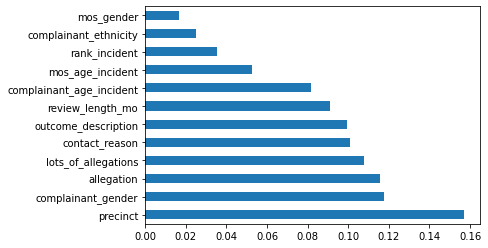

In [195]:

#plot feature importances to the tuned model
feat_importances_tuned = pd.Series(tuned_model_rf.feature_importances_, index=X_train.columns)
feat_importances_tuned.nlargest(20).plot(kind='barh')

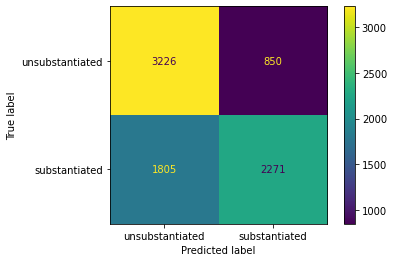

In [226]:
plot_confusion_matrix(tuned_model_rf,
                      X_res_val, #use validation data for confusion matrix
                      y_res_val,
                      values_format='.0f',
                      display_labels=['unsubstantiated', 'substantiated']);

In [197]:
#untuned boosted model

eval_set = [(X_res_val, y_res_val)]
model_boost = XGBClassifier(booster= 'dart',
                  eval_set=eval_set,
                  eval_metric='merror',
                  random_state= 42,
                  n_jobs=-1)

In [227]:
# #reinitialize the test and training data
X_res_train, y_res_train = sm.fit_sample(XT_train, y_train)
X_res_val, y_res_val = sm.fit_sample(XT_val, y_val)

In [228]:
model_boost.fit(X_res_train, y_res_train)

[11:19:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              eval_set=[(array([[  1.        ,   1.        ,   1.        , ...,  62.        ,
         52.        ,   8.        ],
       [  1.        ,   1.        ,   1.        , ...,  24.        ,
         47.        ,  15.        ],
       [  1.        ,   1.        ,   1.        , ...,  32.54620427,
        103.        ,   0.        ],
       ...,
       [  1.        ,   1.        ,   1.13217966, ...,  30.60346103,
        112.47128137,  13.26435932],
       [  1.        ,   1.        ,   1.        , ...,  22.31956692,
         46.        ,   8.        ],
       [  1.35604342,   1.        ,   2.068130...
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=

In [237]:
print("XGBoost training score:",model_boost.score(XT_train, y_train))
print("XGBoost validation score:",model_boost.score(XT_test, y_test))

XGBoost training score: 0.8565832160127318
XGBoost validation score: 0.6950055086301873


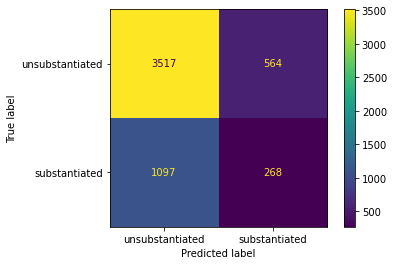

In [238]:
plot_confusion_matrix(model_boost,
                      XT_test, #use validation data for confusion matrix
                      y_test,
                      values_format='.0f',
                      display_labels=['unsubstantiated', 'substantiated']);

In [347]:
#hyper parameter tuning for boost model
  
   
boost_params = {
            'eta': np.arange(0,1,.2),
            'max_depth': range(2,25,2),
            'n_estimators':range(5,85,2),
            'max_delta_step': range(1,10,1)

}

tune_boost = GridSearchCV(model_boost,
                           param_grid =boost_params,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

In [205]:
tune_boost.fit(XT_train, y_train)

NameError: name 'tune_boost' is not defined

In [349]:
tune_boost.best_params_

{'eta': 0.0}

In [240]:
#tuned boosted model, dart was used instead of the default booster to limit over fitting
model_boost_tuned = XGBClassifier(booster='dart',
                            n_estimators= 80,
                            num_parallel_tree= 1,
                            max_delta_step=3,
                            eval_set= eval_set,
                            max_samples=.02,
                            max_depth = 13,
                            random_state= 42,
                            
                            n_jobs=-1)

In [241]:
#reinitialize the test and training data
XT_train = ct.fit_transform(X_train)
XT_val = ct_test.fit_transform(X_test)

In [242]:
model_boost_tuned.fit(X_res_train, y_res_train)

[11:21:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { eval_set, max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_set=[(array([[  1.        ,   1.        ,   1.        , ...,  62.        ,
         52.        ,   8.        ],
       [  1.        ,   1.        ,   1.        , ...,  24.        ,
         47.        ,  15.        ],
       [  1.        ,   1.        ,   1.        , ...,  32.54620427,
        103.        ,   0.        ],
       ...,
       [  1.        ,   1.        ,   1.13217966, ...,  30.60346103,
        112.47128137,  13.26435932],
       [  1.        ,   1.        ,   1.        , ...,  22.31956692,
         46.        ,   8.        ],
       [  1.35604342,   1.        ,   2.06813026, ...,  58.42417368,
        11...
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=3, max_depth=13, max_samples=0.02,
              min_child_weight=1, miss

In [251]:
print("boosted model tuned score",model_boost_tuned.score(X_res_train, y_res_train))
print('boosted model validation score:',model_boost_tuned.score(X_res_val, y_res_val))

boosted model tuned score 0.9955194158645868
boosted model validation score: 0.7349116781157998


boosted model validation score: 0.7349116781157998


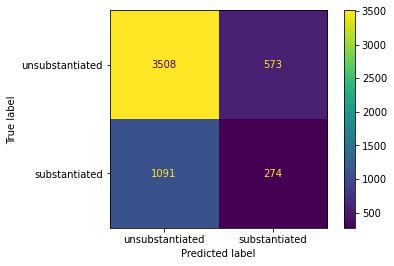

In [245]:
plot_confusion_matrix(model_boost_tuned,
                      XT_test, #use validation data for confusion matrix
                      y_test,
                      values_format='.0f',
                      display_labels=['unsubstantiated', 'substantiated']);

In [246]:
#get the permutation importance for the data sets
perm_imp = permutation_importance(model_boost_tuned,
                                  X_res_val,
                                  y_res_val,
                                  n_jobs=11,
                                  random_state=42)

In [247]:
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

importance_df = pd.DataFrame(data, index=X_test.columns)
importance_df.sort_values(by='importances_mean', inplace=True)

Text(0.5, 1.0, 'Permutation importance for Tuned XGBoost Model')

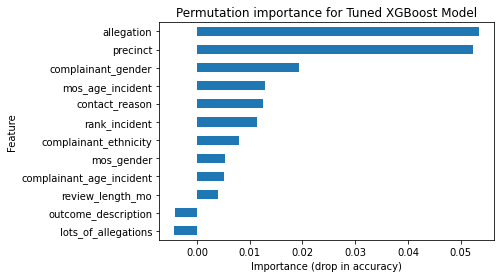

In [252]:
importance_df['importances_mean'].plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for Tuned XGBoost Model')

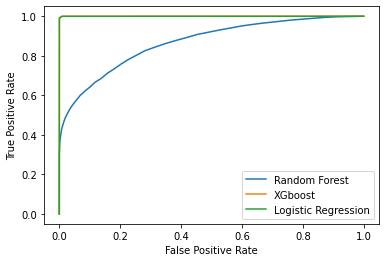

In [250]:
rf =  plot_roc_curve(tuned_model_rf, X_res_train, y_res_train, label='Random Forest')
xgb = plot_roc_curve(model_boost_tuned, X_res_train, y_res_train, ax=rf.ax_, label='XGboost')
logreg = plot_roc_curve(model_boost_tuned, X_res_train, y_res_train, ax=rf.ax_, label='Logistic Regression')
plt.legend;